In [52]:
import pandas as pd
import numpy as np
import math
import sklearn.datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)

IN_COLAB = 'google.colab' in str(get_ipython())

if IN_COLAB:
    !wget https://github.com/AkeemSemper/Intro_to_Machine_Learning_Student_Workbooks/raw/main/data/bodyfat.csv
    df_gb = pd.read_csv("bodyfat.csv")
else:
    df_gb = pd.read_csv("../data/bodyfat.csv")

## Ensemble Models - Random Forest

One common improvement made when using trees is to use several of them, or make a forest instead of a tree. More generally, this is our first look at an ensemble model - combining two or more predictive models to make a final prediction. 

The most simple way to create an ensemble is to use a Random Forest, which generates several trees that make predictions in parallel, then those predictions are combined (for a classification, majority wins) to make the final prediction. The magic behind this is that we are creating several uncorrelated predictions - each tree is generated from a random subset of the data. 

Random forests employ an ensemble method called Bagging, meaning that we run a bunch of models parallel to each other and get the result by combining the individual results; i.e. all the models are in a bag, and we pull out their combined answer. Another ensemble method is called boosting - using the results of one model's predictions to improve another's; we will look at boosting later on. 

Random forests will generally deliver more accuracy and less overfitting than a singular tree. More specifically it will tend to reduce the variance in the predictions, as overfitting tends to 'cancel out' (sklearn's words) when many trees are created independently.

![Random Forest](../images/random_forest.png "Random Forest" )

Using a Random Forest is pretty easy, we can try one with a grid search, and up the number of HPs that we are tuning. Check the documentation page for a look at the parameters that we could use: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

<b>Note:</b> the n_jobs argument is optional, that tells the system to create that number of threads, and those threads will be run in parallel on different cores of the computer. Modern CPUs have a bunch of cores 4-16 or more, so there's potential for some speedup there. My work MacBook I made this on has 4 (which I think can each double thread, to 8). If you get a weird error, just remove this. This isn't really a need to know, but it may speed some stuff up here and there. If someone were doing this on a powerful server you might have 64 cores, so you'd set that number to be high to ensure that calculations went in parallel on each one. 

### Bootstrapping

One key step that we have when using a random forest is bootstrapping, or making the datasets that each of those models in the ensemble use. Bootstrapping generates random sets of data for each model by selecting data from the full training set. Each dataset is the same size as the original data, but it contains items that were selected randomly, with replacement. I.e. if our dataset is 100 items, to create each dataset while bootstrapping we would randomly pick an item from the full data, put that value in the bootstrap set, leave the original in the full dataset (the original data stays at 100 items), and repeat that 100 times. The end result is a bunch of datasets that are very similar to the original, but slightly, and randomly, different. 

This bootstrapping step generates datasets that help the models be more resistant to overfitting, in simple terms it is harder for a model to overfit if the data it is being fit to is different in each of many (in the case of a forest, often 100) models. While one tree model might be able to overfit to its training data, there are very low odds of all 100 models getting a dataset that allows the same overfitting to happen, so the overfit models will be "overruled" when the final vote happens. 

### Feature Sampling

Ensamble models can also apply the same bootstrapping idea to the feature set - rather than use all the features to train the models, take some randomized subset for each model. This is kind of an odd concept, as we are purposefully removing data, but it can be helpful, mainly in combatting overfitting. The core of the idea is the same as the bootstrapping - if each model sees a different variation of the training data, then there's less possibility of the model overfitting to anything in the data.

The max_features parameter in the Decision Tree model defines the number of features the algorithm can consider when looking for the best split. By default, all the features are made available, but we can limit it to a fraction or a specific number of features.

### Load Some Data

This dataset is for predicting breast cancer. The target is binary and the features are a bunch on measurements and test results that could be taken in a screening by a doctor. 

In [38]:
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

df = sklearn_to_df(sklearn.datasets.load_breast_cancer())
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


<h4>Generate Decision Tree Model</h4>

Create a model with the above data and display the resulting decision tree. 

The random state thing is to make it generate the same results each run, that's not really needed in general, but trees can be very different on each training run, so this will make things a little more stable as we explore. 

In [39]:
df2 = pd.get_dummies(df, drop_first=True)
y = np.array(df2["target"])
X = np.array(df2.drop(columns={"target"}))

X_train, X_test, y_train, y_test = train_test_split(X, y)

clf = DecisionTreeClassifier(random_state=10)
clf = clf.fit(X_train, y_train)
print("Depth: ", clf.get_depth())
print("CV Score: ", cross_val_score(clf, X_train, y_train, cv=5) )
#plot_tree(clf)

Depth:  8
CV Score:  [0.89534884 0.97647059 0.88235294 0.98823529 0.90588235]


#### Create Forest

We can create a forest model to compare to the single tree. 

Average Depth:  6.87
CV Score:  [0.95348837 0.97647059 0.97647059 0.98823529 0.95294118]
Test Score:  0.958041958041958


<Axes: xlabel='Predicted', ylabel='Actual'>

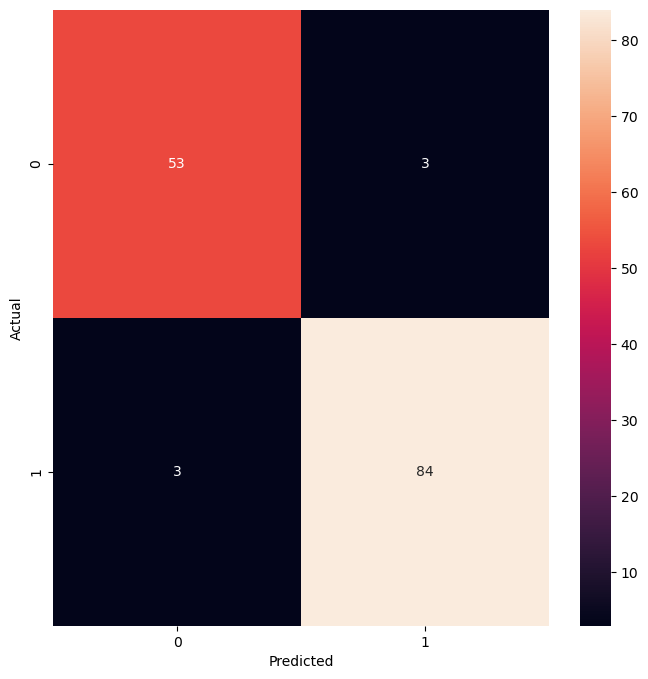

In [40]:
clf_tree = RandomForestClassifier(random_state=10)
clf_tree = clf_tree.fit(X_train, y_train)
print("Average Depth: ", np.mean([estimator.tree_.max_depth for estimator in clf_tree.estimators_]))
print("CV Score: ", cross_val_score(clf_tree, X_train, y_train, cv=5) )
print("Test Score: ", clf_tree.score(X_test, y_test))
clf_tree_preds = clf_tree.predict(X_test)
sns.heatmap(pd.crosstab(y_test, clf_tree_preds, rownames=["Actual"], colnames=["Predicted"]), annot=True, fmt="d")
#plot_tree(clf_tree)

##### Forest with Grid Search

We can also use a grid search to tune the hyperparameters of the forest.

Best Parameters:  {'ccp_alpha': 0, 'max_depth': 2, 'n_estimators': 50}
Average Depth:  2.0
Test Score:  0.958041958041958
CV Score:  [0.90697674 0.97647059 0.94117647 0.97647059 0.95294118]


<Axes: xlabel='Predicted', ylabel='Actual'>

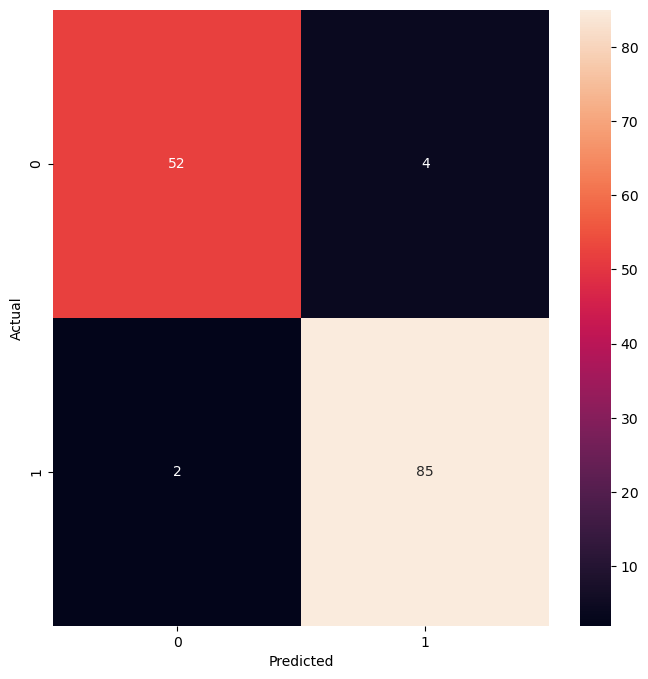

In [41]:
grid_forest = {"n_estimators": [10, 50, 100, 200],
               "ccp_alpha": [0, 0.001, 0.01, 0.1, 1],
               "max_depth": np.linspace(2,10,1).astype(int),
            }

grid_CV_forest = GridSearchCV(RandomForestClassifier(random_state=10, n_jobs=-1), grid_forest, cv=5, n_jobs=-1)
grid_CV_forest.fit(X_train, y_train)
print("Best Parameters: ", grid_CV_forest.best_params_)
print("Average Depth: ", np.mean([estimator.tree_.max_depth for estimator in grid_CV_forest.best_estimator_.estimators_]))
print("Test Score: ", grid_CV_forest.best_estimator_.score(X_test, y_test))
print("CV Score: ", cross_val_score(grid_CV_forest.best_estimator_, X_train, y_train, cv=5) )
grid_CV_preds = grid_CV_forest.best_estimator_.predict(X_test)
sns.heatmap(pd.crosstab(y_test, grid_CV_preds, rownames=["Actual"], colnames=["Predicted"]), annot=True, fmt="d")

### Pipeline, Grid, and Forest Regression

Just as we can make a classification or a regression tree, we can make a regression forest. The idea is exactly the same as with a classification forest, we just create a multitude of regression trees in parallel, use bootstrapping to create the datasets, and then average the results to get the final prediction.

In [54]:
from sklearn.ensemble import RandomForestRegressor
df_reg_pipe = sns.load_dataset("diamonds")
df_reg_pipe.rename(columns={"price":"target"}, inplace=True)

#df_reg_pipe["target"].value_counts()
df_reg_pipe.head()


,carat,cut,color,clarity,depth,table,target,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [65]:
df_reg_pipe.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
carat,53940.0,NaN,NaN,NaN,0.79794,0.474011,0.2,0.4,0.7,1.04,5.01
cut,53940,5,Ideal,21551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color,53940,7,G,11292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clarity,53940,8,SI1,13065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
depth,53940.0,NaN,NaN,NaN,61.749405,1.432621,43.0,61.0,61.8,62.5,79.0
table,53940.0,NaN,NaN,NaN,57.457184,2.234491,43.0,56.0,57.0,59.0,95.0
target,53940.0,NaN,NaN,NaN,3932.799722,3989.439738,326.0,950.0,2401.0,5324.25,18823.0
x,53940.0,NaN,NaN,NaN,5.731157,1.121761,0.0,4.71,5.7,6.54,10.74
y,53940.0,NaN,NaN,NaN,5.734526,1.142135,0.0,4.72,5.71,6.54,58.9
z,53940.0,NaN,NaN,NaN,3.538734,0.705699,0.0,2.91,3.53,4.04,31.8


#### Check Target

Just for fun here, I'm going to check the target variable for the regression dataset. It's a continuous variable, so we can see what the distribution looks like. This is something where it looks like it is log-normal, or skewed substantially. I'm going to try to do a log transform on it to see if we can make it look more normal, then use that as the target. 

<Axes: xlabel='target', ylabel='Density'>

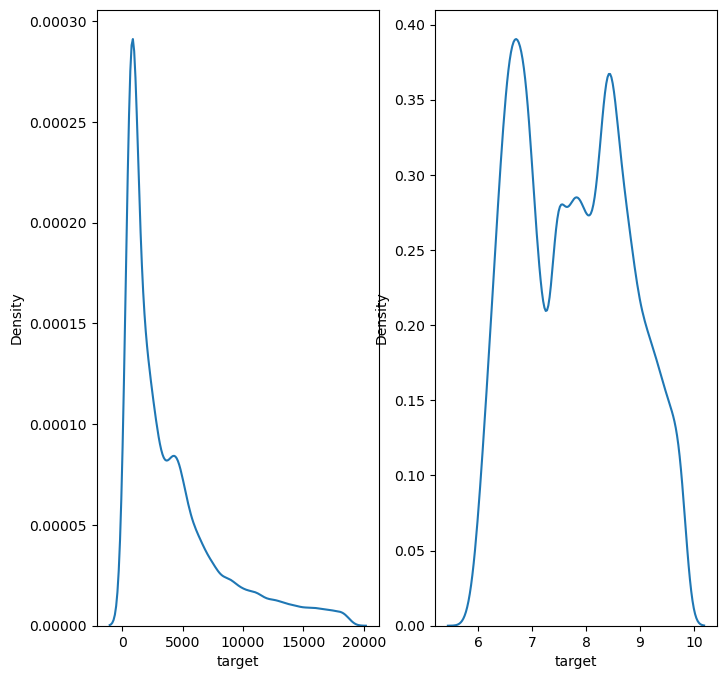

In [64]:
fig, ax = plt.subplots(1,2)
sns.kdeplot(df_reg_pipe["target"], ax=ax[0])
sns.kdeplot(np.log(df_reg_pipe["target"]), ax=ax[1])

In [62]:
X_reg_pipe = df_reg_pipe.drop(columns={"target"})
y_reg_pipe = df_reg_pipe["target"]

X_reg_pipe_cat_cols = ["cut", "color", "clarity"]
X_reg_pipe_num_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']

reg_pipe_cat = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                                ("enc", OneHotEncoder(handle_unknown="ignore"))
                               ])
reg_pipe_num = Pipeline([("imp", SimpleImputer()),
                                ("sca", MinMaxScaler())
                               ])
reg_pipe_ct = ColumnTransformer([("cat", reg_pipe_cat, X_reg_pipe_cat_cols),
                                    ("num", reg_pipe_num, X_reg_pipe_num_cols)
                                    ])
reg_pipe_final = Pipeline([("ct", reg_pipe_ct),
                            ("reg", RandomForestRegressor(random_state=10))
                              ])
reg_pipe_grid = {"reg__n_estimators": [50, 100],
                "reg__ccp_alpha": [0, 0.001, 0.01, 0.1],
                "reg__max_depth": np.linspace(2,7,1).astype(int),
                }
reg_pipe_CV = GridSearchCV(reg_pipe_final, reg_pipe_grid, cv=5, n_jobs=-1, return_train_score=True)
reg_pipe_CV.fit(X_reg_pipe, np.log(y_reg_pipe))
print("Best Parameters: ", reg_pipe_CV.best_params_)
print("Average Depth: ", np.mean([estimator.tree_.max_depth for estimator in reg_pipe_CV.best_estimator_["reg"].estimators_]))
print("Best Score: ", reg_pipe_CV.best_score_)
print("CV Score: ", cross_val_score(reg_pipe_CV.best_estimator_, X_reg_pipe, np.log(y_reg_pipe), cv=5) )
print("Training Scores: ", reg_pipe_CV.cv_results_["mean_train_score"])

Best Parameters:  {'reg__ccp_alpha': 0, 'reg__max_depth': 2, 'reg__n_estimators': 200}
Average Depth:  2.0
Best Score:  -0.19770552541162245
CV Score:  [ 0.32915113  0.37504411  0.8207095  -1.59530814 -0.91812422]
Training Scores:  [0.90590689 0.90822477 0.90837683 0.90830066 0.90590689 0.90822477
 0.90837683 0.90830066 0.90590689 0.90822477 0.90837683 0.90830066
 0.81888463 0.8218435  0.82264596 0.82258    0.15191464 0.16551395
 0.16478003 0.1651836 ]


## Non-Tree Bagging

In general the BaggingClassifier in sklearn can apply the same concept to other classification methods, and the BaggingRegressor can do the same for regression. This just replaces the tree model inside the ensemble with another model, with the rest remaining the same. The bootstraping and feature sampling are still there and work in the same way. The predictions are made by averaging/voting the results of the models in the ensemble.

<Axes: >

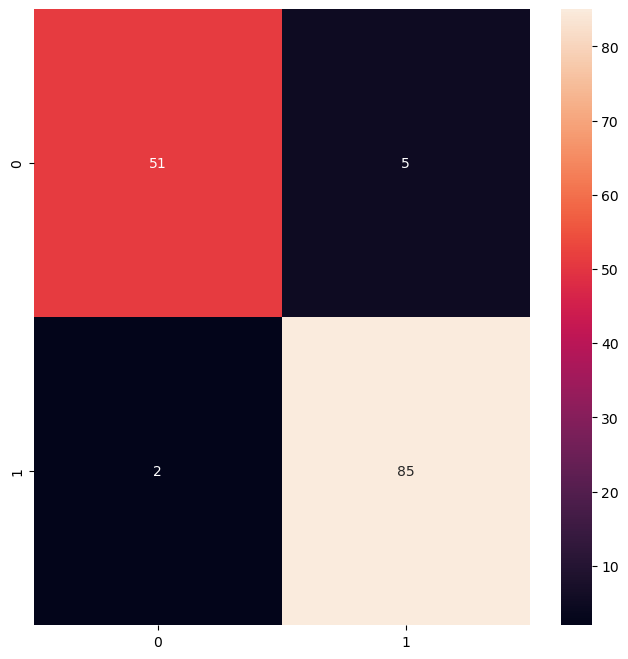

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix

bag = BaggingClassifier(estimator=LogisticRegression(max_iter=10000),n_estimators=10, random_state=0)
bag.fit(X_train, y_train)
bag_preds = bag.predict(X_test)
print("Test Score: ", bag.score(X_test, y_test))
sns.heatmap(confusion_matrix(y_test, bag_preds), annot=True, fmt='d')


## Exercise - Predict the Target


In [44]:
df_ = sklearn_to_df(sklearn.datasets.load_iris())
df_.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
# Solve it


### Gradient Boosting

<b>Note:</b> the details of this are mostly for context. We should understand the basic idea, and how to use the models, but the details of the algorithm are not critical.

The process that gradient boosting uses is:
<ul>
<li> Make an initial set of predictions - this is often done by just making a generic prediction for all records, such as the average. This will generate residuals, or more generally, some measure of loss defined by the loss function. These residuals are the starting point. 
<li> Fit a weak learner with the feature set and the residuals of the previous round. In gradient boosting the weak learners (normally trees) tend to be larger - 8 to 32 nodes. 
<li> Repeat the previous step repeatedly until the limit of number of estimators is reached. 
<li> Predictions are the initial prediction, plus all of the residual predictions averaged together (scaled by the learning rate). This is called shrinkage. 
    <ul>
    <li> y(pred) = y1 + (eta *  r1) + (eta * r2) + ....... + (eta * rN)
    </ul>
</ul>

![Gradient](../images/gradientboosting.png "Gradient" )

So what happens is that the first model makes predictions, and the next one is trained on those residuals. The subsequent models act to "bump" the predictions up or down by trying to correct the errors of the previous model's predictions. Each model adjust the incomming predictions by a bit, until it has eventually been adjusted enough to fit the data (or we hit a size limit). This is why gradient boosting is often called "shrinkage", each additional model shrinks the errors a bit. This process is still relatively fast, as the trees are small and the number of estimators is limited. We can visualize the process like this:

![Gradient Boosting](../images/grad_boost.webp "Gradient Boosting" )

At the end of the fitting process, we end up with a model that starts with an initial prediction, then each subsequent model provides a little adjustment, based on the residuals of the previous model.

![Gradient Boosting](../images/grad_boost.jpg "Gradient Boosting" )

Gradient boosting also works for regression and classification. With the algorithm here it is easier to think of as a regression problem since it is based on residuals.  

For the most part the parameters for gradient boosting are ones that we are familiar with - error metrics, learning rate, tree options (#leafs etc...), and the number of estimators used. Gradient boosting is typically fairly resistant to overfitting, so a large number of estimators will often be better. 

### Be Weak to be Strong

The differentiation between weak and strong predictive models are (this is in the context of classification models):
<ul>
<li> <b>Strong Learners:</b>
    <ul>
    <li> Perform much better than random guessing. 
    <li> Take "more effort" to train and run. 
    <li> Most of the models we look at will fall into this category - logistic regression, SVM, etc...
    </ul>
<li> <b>Weak Learners:</b>
    <ul>
    <li> Perform slightly better than random guessing. 
    <li> Take little time/effort to train or use. 
    <li> "Small" versions of models such as 1 layer trees. 
    </ul>
</ul>

This distinction seems kind of odd at first glance, as there doesn't really seem to be much of a reason to ever use or care about a weak learner - why do we want something that does worse? Ensemble models seek to overcome this by assembling multiple weak (or weaker) models together, taking advantage of the speed and non-overfitting of weak models to generate results that are (ideally) better than a standard strong model. The ensembles we will look at now like a random forest normally combine a bunch of slightly "weaker" (usually not 1 layer, but normally not a massively large tree) models together to create a better model. When we look at boosted (another ensemble technique) ensembles, we'll spend more time on this. 

![Weak Learner](../images/weak_learn.png "Weak Learner" )

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:

y_gbr = df_gb["BodyFat"]
X_gbr = df_gb.drop(columns={"BodyFat"})
df_gb.head()

In [ ]:
gbr = GradientBoostingRegressor()
gbr_pipe = Pipeline([
    ("scale", MinMaxScaler()),
    ("gbc", gbr)
])

Xtr_r, Xte_r, ytr_r, yte_r = train_test_split(X_gbr, y_gbr)
gbr_pipe.fit(X=Xtr_r, y=ytr_r.ravel())

gbr_preds = gbr_pipe.predict(Xte_r)
mean_squared_error(yte_r, gbr_preds, squared=False)

## Exercise - The eXtreme Version!!!!

Use xgboost to create a model for the bodyfat dataset above. Look to the documentation for some options to test in tuning. Google "XGBoost documentation" to find a link to the most recent version's documentation.

If you have time, try to do the same on the diamonds' dataset from higher up. 

In [ ]:
!pip install xgboost
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier